In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
# from torchsummary import summary
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
# from tqdm.notebook import tqdm
from tqdm import tqdm_notebook as tqdm

In [2]:
if torch.cuda.is_available():
    print("The code will run on GPU. This is important so things run faster.")
else:
    print("The code will run on CPU. You should probably not do this.")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on CPU. You should probably not do this.


In [3]:
class dataset:
    def __init__(self,data,target):
        self.data = data
        self.target = target
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        X = self.data[idx]
        y = self.target[idx]
        
        return X,y

In [4]:
data = np.load("armdata.npy")
data = data.reshape(100,100,3)

In [5]:
# temp = [0]*10+[1]*10+[2]*10+[3]*10+[4]*10+[5]*10+[6]*10+[7]*10+[8]*10+[9]*10
# temp = np.array(temp)

# target = np.zeros((100,10))
# for i in range(100):
#     target[i,temp[i]] = 1

In [6]:
target = [0]*10+[1]*10+[2]*10+[3]*10+[4]*10+[5]*10+[6]*10+[7]*10+[8]*10+[9]*10
target = np.array(target)

In [7]:
data = torch.from_numpy(data).float()
target = torch.from_numpy(target).long()

In [8]:
test_idx = np.arange(10)*10
train_idx = np.delete(np.arange(100),test_idx)

data_test = data[test_idx]
data_train = data[train_idx]
target_test = target[test_idx]
target_train = target[train_idx]

trainset = dataset(data_train,target_train)
testset = dataset(data_test,target_test)

In [9]:
batch_size=10

train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

In [10]:
#We define the training as a function so we can easily re-use it.
def train(model, optimizer, num_epochs=10):
    train_acc_all = []
    test_acc_all = []

    for epoch in tqdm(range(num_epochs), unit='epoch'):
        model.train()
        #For each epoch
        train_correct = 0
        for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
            data, target = data.to(device), target.to(device)
            #Zero the gradients computed for each weight
            optimizer.zero_grad()
            #Forward pass your image through the network
            output = model(data)
            #Compute the loss
            loss = F.nll_loss(torch.log(output), target)
            #Backward pass through the network
            loss.backward()
            #Update the weights
            optimizer.step()

            #Compute how many were correctly classified
            predicted = output.argmax(1)
            train_correct += (target==predicted).sum().cpu().item()
        #Comput the test accuracy
        test_correct = 0
        model.eval()
        for data, target in test_loader:
            data = data.to(device)
            with torch.no_grad():
                output = model(data)
            predicted = output.argmax(1).cpu()
            test_correct += (target==predicted).sum().item()
        train_acc = train_correct/len(trainset)
        test_acc = test_correct/len(testset)
        train_acc_all.append(train_acc)
        test_acc_all.append(test_acc)
        print("Accuracy train: {train:.1f}%\t test: {test:.1f}%".format(test=100*test_acc, train=100*train_acc))
    return test_acc_all, train_acc_all

In [26]:
class LinearNet(nn.Module):
    def __init__(self,p):
        super(LinearNet, self).__init__()
        
        self.linear = nn.Sequential(nn.Linear(in_features=300,out_features=500),
                                    nn.ReLU(),
                                    nn.Linear(500,300),
                                    nn.ReLU(),
                                    nn.Dropout(p=p),
                                    nn.Linear(300,200),
                                    nn.ReLU(),
                                    nn.Dropout(p=p),
                                    nn.Linear(200,100),
                                    nn.ReLU(),
                                    nn.Linear(100,10),
                                    nn.Softmax(dim=1))
                                      

        
    def forward(self, x): #x = [batch_size,100,3]
        x = x.view(x.shape[0],-1)
        x = self.linear(x)
        return x


In [29]:
model = LinearNet(p=0.40)
model.to(device)
lr = 1e-4
optimizer = optim.Adam(model.parameters(), lr=lr)

In [30]:
test_acc, train_acc = train(model, optimizer,num_epochs=1000)

Accuracy train: 14.4%	 test: 10.0%


Accuracy train: 7.8%	 test: 10.0%


Accuracy train: 6.7%	 test: 10.0%


Accuracy train: 12.2%	 test: 10.0%


Accuracy train: 8.9%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 4.4%	 test: 10.0%


Accuracy train: 10.0%	 test: 0.0%


Accuracy train: 12.2%	 test: 10.0%


Accuracy train: 8.9%	 test: 10.0%


Accuracy train: 6.7%	 test: 10.0%


Accuracy train: 13.3%	 test: 10.0%


Accuracy train: 8.9%	 test: 10.0%


Accuracy train: 7.8%	 test: 10.0%


Accuracy train: 13.3%	 test: 20.0%


Accuracy train: 8.9%	 test: 20.0%


Accuracy train: 20.0%	 test: 20.0%


Accuracy train: 15.6%	 test: 40.0%


Accuracy train: 15.6%	 test: 30.0%


Accuracy train: 11.1%	 test: 10.0%


Accuracy train: 21.1%	 test: 20.0%


Accuracy train: 16.7%	 test: 20.0%


Accuracy train: 16.7%	 test: 20.0%


Accuracy train: 16.7%	 test: 10.0%


Accuracy train: 16.7%	 test: 10.0%


Accuracy train: 20.0%	 test: 20.0%


Accuracy train: 16.7%	 test: 20.0%


Accuracy train: 21.1%	 test: 20.0%


Accuracy train: 25.6%	 test: 30.0%


Accuracy train: 18.9%	 test: 20.0%


Accuracy train: 23.3%	 test: 20.0%


Accuracy train: 18.9%	 test: 10.0%


Accuracy train: 24.4%	 test: 10.0%


Accuracy train: 21.1%	 test: 10.0%


Accuracy train: 31.1%	 test: 10.0%


Accuracy train: 23.3%	 test: 10.0%


Accuracy train: 26.7%	 test: 20.0%


Accuracy train: 18.9%	 test: 30.0%


Accuracy train: 18.9%	 test: 20.0%


Accuracy train: 20.0%	 test: 30.0%


Accuracy train: 26.7%	 test: 30.0%


Accuracy train: 25.6%	 test: 20.0%


Accuracy train: 28.9%	 test: 40.0%


Accuracy train: 25.6%	 test: 20.0%


Accuracy train: 33.3%	 test: 30.0%


Accuracy train: 31.1%	 test: 30.0%


Accuracy train: 34.4%	 test: 20.0%


Accuracy train: 27.8%	 test: 30.0%


Accuracy train: 34.4%	 test: 20.0%


Accuracy train: 32.2%	 test: 20.0%


Accuracy train: 26.7%	 test: 20.0%


Accuracy train: 34.4%	 test: 30.0%


Accuracy train: 41.1%	 test: 30.0%


Accuracy train: 33.3%	 test: 30.0%


Accuracy train: 34.4%	 test: 40.0%


Accuracy train: 32.2%	 test: 20.0%


Accuracy train: 35.6%	 test: 30.0%


Accuracy train: 33.3%	 test: 30.0%


Accuracy train: 38.9%	 test: 30.0%


Accuracy train: 32.2%	 test: 30.0%


Accuracy train: 31.1%	 test: 20.0%


Accuracy train: 42.2%	 test: 40.0%


Accuracy train: 31.1%	 test: 20.0%


Accuracy train: 43.3%	 test: 30.0%


Accuracy train: 37.8%	 test: 30.0%


Accuracy train: 42.2%	 test: 20.0%


Accuracy train: 40.0%	 test: 10.0%


Accuracy train: 42.2%	 test: 10.0%


Accuracy train: 45.6%	 test: 30.0%


Accuracy train: 40.0%	 test: 20.0%


Accuracy train: 44.4%	 test: 30.0%


Accuracy train: 47.8%	 test: 40.0%


Accuracy train: 41.1%	 test: 20.0%


Accuracy train: 41.1%	 test: 30.0%


Accuracy train: 42.2%	 test: 10.0%


Accuracy train: 37.8%	 test: 40.0%


Accuracy train: 44.4%	 test: 10.0%


Accuracy train: 48.9%	 test: 20.0%


Accuracy train: 50.0%	 test: 40.0%


Accuracy train: 43.3%	 test: 20.0%


Accuracy train: 46.7%	 test: 10.0%


Accuracy train: 45.6%	 test: 30.0%


Accuracy train: 47.8%	 test: 10.0%


Accuracy train: 47.8%	 test: 30.0%


Accuracy train: 60.0%	 test: 10.0%


Accuracy train: 48.9%	 test: 20.0%


Accuracy train: 50.0%	 test: 30.0%


Accuracy train: 56.7%	 test: 30.0%


Accuracy train: 50.0%	 test: 20.0%


Accuracy train: 46.7%	 test: 0.0%


Accuracy train: 55.6%	 test: 30.0%


Accuracy train: 47.8%	 test: 0.0%


Accuracy train: 62.2%	 test: 30.0%


Accuracy train: 50.0%	 test: 30.0%


Accuracy train: 57.8%	 test: 20.0%


Accuracy train: 61.1%	 test: 0.0%


Accuracy train: 55.6%	 test: 20.0%


Accuracy train: 56.7%	 test: 20.0%


Accuracy train: 57.8%	 test: 20.0%


Accuracy train: 55.6%	 test: 30.0%


Accuracy train: 65.6%	 test: 20.0%


Accuracy train: 58.9%	 test: 20.0%


Accuracy train: 55.6%	 test: 20.0%


Accuracy train: 57.8%	 test: 20.0%


Accuracy train: 64.4%	 test: 20.0%


Accuracy train: 61.1%	 test: 20.0%


Accuracy train: 64.4%	 test: 10.0%


Accuracy train: 62.2%	 test: 20.0%


Accuracy train: 62.2%	 test: 0.0%


Accuracy train: 64.4%	 test: 20.0%


Accuracy train: 54.4%	 test: 10.0%


Accuracy train: 57.8%	 test: 20.0%


Accuracy train: 70.0%	 test: 20.0%


Accuracy train: 55.6%	 test: 20.0%


Accuracy train: 57.8%	 test: 20.0%


Accuracy train: 62.2%	 test: 20.0%


Accuracy train: 64.4%	 test: 10.0%


Accuracy train: 61.1%	 test: 30.0%


Accuracy train: 61.1%	 test: 20.0%


Accuracy train: 57.8%	 test: 20.0%


Accuracy train: 70.0%	 test: 30.0%


Accuracy train: 64.4%	 test: 20.0%


Accuracy train: 58.9%	 test: 20.0%


Accuracy train: 63.3%	 test: 20.0%


Accuracy train: 64.4%	 test: 20.0%


Accuracy train: 66.7%	 test: 20.0%


Accuracy train: 64.4%	 test: 20.0%


Accuracy train: 56.7%	 test: 20.0%


Accuracy train: 70.0%	 test: 20.0%


Accuracy train: 65.6%	 test: 20.0%


Accuracy train: 71.1%	 test: 20.0%


Accuracy train: 63.3%	 test: 20.0%


Accuracy train: 62.2%	 test: 20.0%


Accuracy train: 66.7%	 test: 20.0%


Accuracy train: 67.8%	 test: 10.0%


Accuracy train: 64.4%	 test: 20.0%


Accuracy train: 64.4%	 test: 10.0%


Accuracy train: 72.2%	 test: 20.0%


Accuracy train: 60.0%	 test: 10.0%


Accuracy train: 62.2%	 test: 20.0%


Accuracy train: 75.6%	 test: 30.0%


Accuracy train: 65.6%	 test: 10.0%


Accuracy train: 67.8%	 test: 20.0%


Accuracy train: 65.6%	 test: 10.0%


Accuracy train: 72.2%	 test: 20.0%


Accuracy train: 74.4%	 test: 20.0%


Accuracy train: 75.6%	 test: 20.0%


Accuracy train: 72.2%	 test: 30.0%


Accuracy train: 75.6%	 test: 20.0%


Accuracy train: 72.2%	 test: 30.0%


Accuracy train: 71.1%	 test: 20.0%


Accuracy train: 68.9%	 test: 20.0%


Accuracy train: 71.1%	 test: 20.0%


Accuracy train: 70.0%	 test: 20.0%


Accuracy train: 72.2%	 test: 20.0%


Accuracy train: 67.8%	 test: 40.0%


Accuracy train: 67.8%	 test: 20.0%


Accuracy train: 66.7%	 test: 20.0%


Accuracy train: 73.3%	 test: 20.0%


Accuracy train: 74.4%	 test: 20.0%


Accuracy train: 72.2%	 test: 20.0%


Accuracy train: 68.9%	 test: 20.0%


Accuracy train: 63.3%	 test: 20.0%


Accuracy train: 68.9%	 test: 20.0%


Accuracy train: 67.8%	 test: 20.0%


Accuracy train: 75.6%	 test: 20.0%


Accuracy train: 71.1%	 test: 30.0%


Accuracy train: 70.0%	 test: 30.0%


Accuracy train: 72.2%	 test: 30.0%


Accuracy train: 72.2%	 test: 10.0%


Accuracy train: 75.6%	 test: 20.0%


Accuracy train: 77.8%	 test: 20.0%


Accuracy train: 74.4%	 test: 20.0%


Accuracy train: 74.4%	 test: 20.0%


Accuracy train: 70.0%	 test: 20.0%


Accuracy train: 72.2%	 test: 20.0%


Accuracy train: 78.9%	 test: 20.0%


Accuracy train: 76.7%	 test: 40.0%


Accuracy train: 76.7%	 test: 30.0%


Accuracy train: 71.1%	 test: 40.0%


Accuracy train: 71.1%	 test: 20.0%


Accuracy train: 76.7%	 test: 30.0%


Accuracy train: 65.6%	 test: 20.0%


Accuracy train: 77.8%	 test: 30.0%


Accuracy train: 76.7%	 test: 30.0%


Accuracy train: 76.7%	 test: 20.0%


Accuracy train: 72.2%	 test: 30.0%


Accuracy train: 64.4%	 test: 20.0%


Accuracy train: 80.0%	 test: 20.0%


Accuracy train: 80.0%	 test: 20.0%


Accuracy train: 74.4%	 test: 30.0%


Accuracy train: 76.7%	 test: 40.0%


Accuracy train: 75.6%	 test: 40.0%


Accuracy train: 77.8%	 test: 20.0%


Accuracy train: 75.6%	 test: 30.0%


Accuracy train: 80.0%	 test: 40.0%


Accuracy train: 83.3%	 test: 30.0%


Accuracy train: 80.0%	 test: 30.0%


Accuracy train: 77.8%	 test: 30.0%


Accuracy train: 86.7%	 test: 30.0%


Accuracy train: 83.3%	 test: 40.0%


Accuracy train: 81.1%	 test: 20.0%


Accuracy train: 77.8%	 test: 30.0%


Accuracy train: 80.0%	 test: 20.0%


Accuracy train: 82.2%	 test: 40.0%


Accuracy train: 76.7%	 test: 40.0%


Accuracy train: 77.8%	 test: 30.0%


Accuracy train: 78.9%	 test: 30.0%


Accuracy train: 77.8%	 test: 20.0%


Accuracy train: 75.6%	 test: 30.0%


Accuracy train: 83.3%	 test: 30.0%


Accuracy train: 88.9%	 test: 40.0%


Accuracy train: 85.6%	 test: 40.0%


Accuracy train: 77.8%	 test: 40.0%


Accuracy train: 83.3%	 test: 30.0%


Accuracy train: 84.4%	 test: 40.0%


Accuracy train: 73.3%	 test: 30.0%


Accuracy train: 75.6%	 test: 40.0%


Accuracy train: 81.1%	 test: 20.0%


Accuracy train: 82.2%	 test: 40.0%


Accuracy train: 78.9%	 test: 40.0%


Accuracy train: 78.9%	 test: 30.0%


Accuracy train: 85.6%	 test: 40.0%


Accuracy train: 84.4%	 test: 30.0%


Accuracy train: 83.3%	 test: 30.0%


Accuracy train: 80.0%	 test: 40.0%


Accuracy train: 82.2%	 test: 30.0%


Accuracy train: 78.9%	 test: 40.0%


Accuracy train: 81.1%	 test: 40.0%


Accuracy train: 82.2%	 test: 40.0%


Accuracy train: 82.2%	 test: 30.0%


Accuracy train: 86.7%	 test: 40.0%


Accuracy train: 85.6%	 test: 20.0%


Accuracy train: 82.2%	 test: 40.0%


Accuracy train: 77.8%	 test: 40.0%


Accuracy train: 80.0%	 test: 30.0%


Accuracy train: 84.4%	 test: 30.0%


Accuracy train: 83.3%	 test: 40.0%


Accuracy train: 85.6%	 test: 30.0%


Accuracy train: 83.3%	 test: 30.0%


Accuracy train: 85.6%	 test: 40.0%


Accuracy train: 82.2%	 test: 30.0%


Accuracy train: 80.0%	 test: 30.0%


Accuracy train: 85.6%	 test: 20.0%


Accuracy train: 85.6%	 test: 40.0%


Accuracy train: 83.3%	 test: 20.0%


Accuracy train: 80.0%	 test: 40.0%


Accuracy train: 87.8%	 test: 20.0%


Accuracy train: 85.6%	 test: 30.0%


Accuracy train: 84.4%	 test: 20.0%


Accuracy train: 87.8%	 test: 40.0%


Accuracy train: 83.3%	 test: 20.0%


Accuracy train: 81.1%	 test: 40.0%


Accuracy train: 86.7%	 test: 40.0%


Accuracy train: 84.4%	 test: 40.0%


Accuracy train: 83.3%	 test: 30.0%


Accuracy train: 85.6%	 test: 40.0%


Accuracy train: 84.4%	 test: 40.0%


Accuracy train: 84.4%	 test: 20.0%


Accuracy train: 81.1%	 test: 30.0%


Accuracy train: 75.6%	 test: 30.0%


Accuracy train: 84.4%	 test: 20.0%


Accuracy train: 88.9%	 test: 40.0%


Accuracy train: 87.8%	 test: 30.0%


Accuracy train: 86.7%	 test: 30.0%


Accuracy train: 87.8%	 test: 40.0%


Accuracy train: 86.7%	 test: 30.0%


Accuracy train: 84.4%	 test: 40.0%


Accuracy train: 87.8%	 test: 40.0%


Accuracy train: 92.2%	 test: 50.0%


Accuracy train: 91.1%	 test: 30.0%


Accuracy train: 85.6%	 test: 40.0%


Accuracy train: 87.8%	 test: 40.0%


Accuracy train: 86.7%	 test: 50.0%


Accuracy train: 87.8%	 test: 30.0%


Accuracy train: 83.3%	 test: 40.0%


Accuracy train: 87.8%	 test: 30.0%


Accuracy train: 87.8%	 test: 40.0%


Accuracy train: 84.4%	 test: 40.0%


Accuracy train: 82.2%	 test: 40.0%


Accuracy train: 86.7%	 test: 40.0%


Accuracy train: 90.0%	 test: 30.0%


Accuracy train: 83.3%	 test: 30.0%


Accuracy train: 83.3%	 test: 20.0%


Accuracy train: 86.7%	 test: 40.0%


Accuracy train: 88.9%	 test: 30.0%


Accuracy train: 88.9%	 test: 40.0%


Accuracy train: 85.6%	 test: 30.0%


Accuracy train: 86.7%	 test: 50.0%


Accuracy train: 92.2%	 test: 50.0%


Accuracy train: 90.0%	 test: 30.0%


Accuracy train: 92.2%	 test: 40.0%


Accuracy train: 84.4%	 test: 40.0%


Accuracy train: 90.0%	 test: 30.0%


Accuracy train: 84.4%	 test: 50.0%


Accuracy train: 86.7%	 test: 40.0%


Accuracy train: 84.4%	 test: 50.0%


Accuracy train: 85.6%	 test: 40.0%


Accuracy train: 85.6%	 test: 40.0%


Accuracy train: 86.7%	 test: 50.0%


Accuracy train: 84.4%	 test: 40.0%


Accuracy train: 91.1%	 test: 30.0%


Accuracy train: 88.9%	 test: 40.0%


Accuracy train: 88.9%	 test: 30.0%


Accuracy train: 86.7%	 test: 40.0%


Accuracy train: 87.8%	 test: 30.0%


Accuracy train: 88.9%	 test: 40.0%


Accuracy train: 92.2%	 test: 40.0%


Accuracy train: 88.9%	 test: 40.0%


Accuracy train: 88.9%	 test: 50.0%


Accuracy train: 88.9%	 test: 60.0%


Accuracy train: 87.8%	 test: 40.0%


Accuracy train: 90.0%	 test: 40.0%


Accuracy train: 91.1%	 test: 50.0%


Accuracy train: 90.0%	 test: 40.0%


Accuracy train: 88.9%	 test: 40.0%


Accuracy train: 87.8%	 test: 60.0%


Accuracy train: 91.1%	 test: 30.0%


Accuracy train: 91.1%	 test: 60.0%


Accuracy train: 85.6%	 test: 30.0%


Accuracy train: 91.1%	 test: 50.0%


Accuracy train: 88.9%	 test: 40.0%


Accuracy train: 88.9%	 test: 40.0%


Accuracy train: 90.0%	 test: 50.0%


Accuracy train: 88.9%	 test: 30.0%


Accuracy train: 90.0%	 test: 40.0%


Accuracy train: 88.9%	 test: 40.0%


Accuracy train: 85.6%	 test: 50.0%


Accuracy train: 88.9%	 test: 40.0%


Accuracy train: 91.1%	 test: 40.0%


Accuracy train: 93.3%	 test: 30.0%


Accuracy train: 95.6%	 test: 40.0%


Accuracy train: 91.1%	 test: 30.0%


Accuracy train: 92.2%	 test: 40.0%


Accuracy train: 90.0%	 test: 30.0%


Accuracy train: 92.2%	 test: 60.0%


Accuracy train: 86.7%	 test: 40.0%


Accuracy train: 87.8%	 test: 30.0%


Accuracy train: 87.8%	 test: 50.0%


Accuracy train: 88.9%	 test: 30.0%


Accuracy train: 86.7%	 test: 60.0%


Accuracy train: 91.1%	 test: 40.0%


Accuracy train: 93.3%	 test: 40.0%


Accuracy train: 87.8%	 test: 40.0%


Accuracy train: 90.0%	 test: 50.0%


Accuracy train: 92.2%	 test: 40.0%


Accuracy train: 88.9%	 test: 40.0%


Accuracy train: 90.0%	 test: 30.0%


Accuracy train: 92.2%	 test: 40.0%


Accuracy train: 91.1%	 test: 30.0%


Accuracy train: 90.0%	 test: 50.0%


Accuracy train: 90.0%	 test: 40.0%


Accuracy train: 87.8%	 test: 30.0%


Accuracy train: 86.7%	 test: 60.0%


Accuracy train: 92.2%	 test: 30.0%


Accuracy train: 93.3%	 test: 60.0%


Accuracy train: 82.2%	 test: 50.0%


Accuracy train: 86.7%	 test: 40.0%


Accuracy train: 94.4%	 test: 40.0%


Accuracy train: 91.1%	 test: 50.0%


Accuracy train: 92.2%	 test: 40.0%


Accuracy train: 95.6%	 test: 50.0%


Accuracy train: 92.2%	 test: 40.0%


Accuracy train: 92.2%	 test: 70.0%


Accuracy train: 92.2%	 test: 30.0%


Accuracy train: 88.9%	 test: 50.0%


Accuracy train: 90.0%	 test: 40.0%


Accuracy train: 90.0%	 test: 70.0%


Accuracy train: 91.1%	 test: 40.0%


Accuracy train: 90.0%	 test: 60.0%


Accuracy train: 88.9%	 test: 40.0%


Accuracy train: 92.2%	 test: 40.0%


Accuracy train: 90.0%	 test: 60.0%


Accuracy train: 93.3%	 test: 60.0%


Accuracy train: 93.3%	 test: 40.0%


Accuracy train: 91.1%	 test: 30.0%


Accuracy train: 91.1%	 test: 40.0%


Accuracy train: 95.6%	 test: 50.0%


Accuracy train: 90.0%	 test: 60.0%


Accuracy train: 88.9%	 test: 60.0%


Accuracy train: 91.1%	 test: 40.0%


Accuracy train: 88.9%	 test: 40.0%


Accuracy train: 88.9%	 test: 40.0%


Accuracy train: 90.0%	 test: 60.0%


Accuracy train: 94.4%	 test: 40.0%


Accuracy train: 93.3%	 test: 70.0%


Accuracy train: 93.3%	 test: 40.0%


Accuracy train: 90.0%	 test: 60.0%


Accuracy train: 88.9%	 test: 40.0%


Accuracy train: 94.4%	 test: 40.0%


Accuracy train: 94.4%	 test: 60.0%


Accuracy train: 92.2%	 test: 50.0%


Accuracy train: 94.4%	 test: 40.0%


Accuracy train: 90.0%	 test: 50.0%


Accuracy train: 86.7%	 test: 50.0%


Accuracy train: 92.2%	 test: 40.0%


Accuracy train: 88.9%	 test: 60.0%


Accuracy train: 93.3%	 test: 40.0%


Accuracy train: 94.4%	 test: 50.0%


Accuracy train: 91.1%	 test: 50.0%


Accuracy train: 90.0%	 test: 50.0%


Accuracy train: 90.0%	 test: 50.0%


Accuracy train: 90.0%	 test: 50.0%


Accuracy train: 85.6%	 test: 40.0%


Accuracy train: 93.3%	 test: 50.0%


Accuracy train: 91.1%	 test: 50.0%


Accuracy train: 91.1%	 test: 40.0%


Accuracy train: 96.7%	 test: 60.0%


Accuracy train: 93.3%	 test: 50.0%


Accuracy train: 91.1%	 test: 50.0%


Accuracy train: 94.4%	 test: 40.0%


Accuracy train: 95.6%	 test: 30.0%


Accuracy train: 91.1%	 test: 40.0%


Accuracy train: 95.6%	 test: 40.0%


Accuracy train: 93.3%	 test: 40.0%


Accuracy train: 90.0%	 test: 50.0%


Accuracy train: 91.1%	 test: 30.0%


Accuracy train: 91.1%	 test: 50.0%


Accuracy train: 95.6%	 test: 50.0%


Accuracy train: 92.2%	 test: 50.0%


Accuracy train: 95.6%	 test: 60.0%


Accuracy train: 92.2%	 test: 40.0%


Accuracy train: 96.7%	 test: 50.0%


Accuracy train: 94.4%	 test: 50.0%


Accuracy train: 94.4%	 test: 40.0%


Accuracy train: 88.9%	 test: 50.0%


Accuracy train: 92.2%	 test: 50.0%


Accuracy train: 95.6%	 test: 40.0%


Accuracy train: 93.3%	 test: 60.0%


Accuracy train: 95.6%	 test: 50.0%


Accuracy train: 95.6%	 test: 50.0%


Accuracy train: 96.7%	 test: 50.0%


Accuracy train: 93.3%	 test: 40.0%


Accuracy train: 97.8%	 test: 70.0%


Accuracy train: 92.2%	 test: 50.0%


Accuracy train: 94.4%	 test: 60.0%


Accuracy train: 96.7%	 test: 50.0%


Accuracy train: 88.9%	 test: 50.0%


Accuracy train: 91.1%	 test: 50.0%


Accuracy train: 92.2%	 test: 50.0%


Accuracy train: 97.8%	 test: 50.0%


Accuracy train: 93.3%	 test: 40.0%


Accuracy train: 94.4%	 test: 60.0%


Accuracy train: 95.6%	 test: 50.0%


Accuracy train: 96.7%	 test: 50.0%


Accuracy train: 91.1%	 test: 50.0%


Accuracy train: 94.4%	 test: 60.0%


Accuracy train: 95.6%	 test: 60.0%


Accuracy train: 93.3%	 test: 50.0%


Accuracy train: 94.4%	 test: 60.0%


Accuracy train: 90.0%	 test: 40.0%


Accuracy train: 88.9%	 test: 50.0%


Accuracy train: 96.7%	 test: 50.0%


Accuracy train: 94.4%	 test: 70.0%


Accuracy train: 93.3%	 test: 30.0%


Accuracy train: 93.3%	 test: 60.0%


Accuracy train: 95.6%	 test: 40.0%


Accuracy train: 91.1%	 test: 50.0%


Accuracy train: 92.2%	 test: 50.0%


Accuracy train: 92.2%	 test: 50.0%


Accuracy train: 90.0%	 test: 60.0%


Accuracy train: 90.0%	 test: 50.0%


Accuracy train: 91.1%	 test: 70.0%


Accuracy train: 92.2%	 test: 50.0%


Accuracy train: 92.2%	 test: 60.0%


Accuracy train: 92.2%	 test: 50.0%


Accuracy train: 97.8%	 test: 50.0%


Accuracy train: 96.7%	 test: 60.0%


Accuracy train: 95.6%	 test: 50.0%


Accuracy train: 95.6%	 test: 60.0%


Accuracy train: 94.4%	 test: 50.0%


Accuracy train: 93.3%	 test: 50.0%


Accuracy train: 92.2%	 test: 50.0%


Accuracy train: 92.2%	 test: 60.0%


Accuracy train: 97.8%	 test: 60.0%


Accuracy train: 94.4%	 test: 50.0%


Accuracy train: 94.4%	 test: 50.0%


Accuracy train: 91.1%	 test: 50.0%


Accuracy train: 94.4%	 test: 50.0%


Accuracy train: 91.1%	 test: 60.0%


Accuracy train: 96.7%	 test: 50.0%


Accuracy train: 91.1%	 test: 70.0%


Accuracy train: 98.9%	 test: 60.0%


Accuracy train: 96.7%	 test: 50.0%


Accuracy train: 95.6%	 test: 50.0%


Accuracy train: 94.4%	 test: 50.0%


Accuracy train: 94.4%	 test: 50.0%


Accuracy train: 95.6%	 test: 50.0%


Accuracy train: 96.7%	 test: 50.0%


Accuracy train: 95.6%	 test: 50.0%


Accuracy train: 96.7%	 test: 40.0%


Accuracy train: 94.4%	 test: 70.0%


Accuracy train: 94.4%	 test: 50.0%


Accuracy train: 95.6%	 test: 50.0%


Accuracy train: 94.4%	 test: 60.0%


Accuracy train: 93.3%	 test: 50.0%


Accuracy train: 93.3%	 test: 60.0%


Accuracy train: 95.6%	 test: 50.0%


Accuracy train: 94.4%	 test: 60.0%


Accuracy train: 93.3%	 test: 60.0%


Accuracy train: 93.3%	 test: 40.0%


Accuracy train: 96.7%	 test: 60.0%


Accuracy train: 94.4%	 test: 60.0%


Accuracy train: 97.8%	 test: 50.0%


Accuracy train: 97.8%	 test: 40.0%


Accuracy train: 97.8%	 test: 50.0%


Accuracy train: 96.7%	 test: 60.0%


Accuracy train: 97.8%	 test: 40.0%


Accuracy train: 96.7%	 test: 50.0%


Accuracy train: 94.4%	 test: 40.0%


Accuracy train: 95.6%	 test: 50.0%


Accuracy train: 93.3%	 test: 50.0%


Accuracy train: 93.3%	 test: 50.0%


Accuracy train: 95.6%	 test: 60.0%


Accuracy train: 96.7%	 test: 50.0%


Accuracy train: 94.4%	 test: 30.0%


Accuracy train: 95.6%	 test: 70.0%


Accuracy train: 95.6%	 test: 50.0%


Accuracy train: 97.8%	 test: 50.0%


Accuracy train: 96.7%	 test: 60.0%


Accuracy train: 95.6%	 test: 60.0%


Accuracy train: 93.3%	 test: 50.0%


Accuracy train: 93.3%	 test: 40.0%


Accuracy train: 92.2%	 test: 50.0%


Accuracy train: 95.6%	 test: 50.0%


Accuracy train: 95.6%	 test: 40.0%


Accuracy train: 96.7%	 test: 50.0%


Accuracy train: 96.7%	 test: 40.0%


Accuracy train: 96.7%	 test: 40.0%


Accuracy train: 93.3%	 test: 40.0%


Accuracy train: 94.4%	 test: 40.0%


Accuracy train: 94.4%	 test: 60.0%


Accuracy train: 91.1%	 test: 50.0%


Accuracy train: 94.4%	 test: 40.0%


Accuracy train: 96.7%	 test: 50.0%


Accuracy train: 94.4%	 test: 40.0%


Accuracy train: 94.4%	 test: 40.0%


Accuracy train: 96.7%	 test: 70.0%


Accuracy train: 97.8%	 test: 50.0%


Accuracy train: 95.6%	 test: 50.0%


Accuracy train: 93.3%	 test: 60.0%


Accuracy train: 96.7%	 test: 50.0%


Accuracy train: 95.6%	 test: 50.0%


Accuracy train: 95.6%	 test: 50.0%


Accuracy train: 93.3%	 test: 60.0%


Accuracy train: 94.4%	 test: 30.0%


Accuracy train: 95.6%	 test: 60.0%


Accuracy train: 94.4%	 test: 60.0%


Accuracy train: 95.6%	 test: 60.0%


Accuracy train: 93.3%	 test: 60.0%


Accuracy train: 95.6%	 test: 50.0%


Accuracy train: 97.8%	 test: 50.0%


Accuracy train: 94.4%	 test: 50.0%


Accuracy train: 95.6%	 test: 50.0%


Accuracy train: 95.6%	 test: 40.0%


Accuracy train: 94.4%	 test: 60.0%


Accuracy train: 94.4%	 test: 50.0%


Accuracy train: 92.2%	 test: 40.0%


Accuracy train: 96.7%	 test: 70.0%


Accuracy train: 96.7%	 test: 60.0%


Accuracy train: 96.7%	 test: 50.0%


Accuracy train: 95.6%	 test: 50.0%


Accuracy train: 97.8%	 test: 50.0%


Accuracy train: 98.9%	 test: 50.0%


Accuracy train: 93.3%	 test: 50.0%


Accuracy train: 94.4%	 test: 50.0%


Accuracy train: 96.7%	 test: 60.0%


Accuracy train: 96.7%	 test: 50.0%


Accuracy train: 95.6%	 test: 50.0%


Accuracy train: 94.4%	 test: 50.0%


Accuracy train: 94.4%	 test: 50.0%


Accuracy train: 90.0%	 test: 40.0%


Accuracy train: 90.0%	 test: 40.0%


Accuracy train: 90.0%	 test: 50.0%


Accuracy train: 90.0%	 test: 50.0%


Accuracy train: 92.2%	 test: 50.0%


Accuracy train: 92.2%	 test: 50.0%


Accuracy train: 97.8%	 test: 50.0%


Accuracy train: 97.8%	 test: 50.0%


Accuracy train: 93.3%	 test: 40.0%


Accuracy train: 96.7%	 test: 50.0%


Accuracy train: 96.7%	 test: 30.0%


Accuracy train: 97.8%	 test: 60.0%


Accuracy train: 97.8%	 test: 60.0%


Accuracy train: 96.7%	 test: 40.0%


Accuracy train: 98.9%	 test: 60.0%


Accuracy train: 98.9%	 test: 50.0%


Accuracy train: 96.7%	 test: 60.0%


Accuracy train: 98.9%	 test: 50.0%


Accuracy train: 97.8%	 test: 60.0%


Accuracy train: 95.6%	 test: 70.0%


Accuracy train: 97.8%	 test: 60.0%


Accuracy train: 95.6%	 test: 60.0%


Accuracy train: 96.7%	 test: 60.0%


Accuracy train: 93.3%	 test: 40.0%


Accuracy train: 96.7%	 test: 60.0%


Accuracy train: 95.6%	 test: 50.0%


Accuracy train: 96.7%	 test: 50.0%


Accuracy train: 97.8%	 test: 70.0%


Accuracy train: 98.9%	 test: 50.0%


Accuracy train: 97.8%	 test: 40.0%


Accuracy train: 96.7%	 test: 50.0%


Accuracy train: 96.7%	 test: 60.0%


Accuracy train: 100.0%	 test: 50.0%


Accuracy train: 98.9%	 test: 60.0%


Accuracy train: 96.7%	 test: 50.0%


Accuracy train: 98.9%	 test: 40.0%


Accuracy train: 98.9%	 test: 60.0%


Accuracy train: 95.6%	 test: 40.0%


Accuracy train: 97.8%	 test: 40.0%


Accuracy train: 98.9%	 test: 60.0%


Accuracy train: 100.0%	 test: 40.0%


Accuracy train: 95.6%	 test: 40.0%


Accuracy train: 90.0%	 test: 60.0%


Accuracy train: 97.8%	 test: 50.0%


Accuracy train: 95.6%	 test: 40.0%


Accuracy train: 97.8%	 test: 60.0%


Accuracy train: 97.8%	 test: 50.0%


Accuracy train: 96.7%	 test: 50.0%


Accuracy train: 97.8%	 test: 40.0%


Accuracy train: 98.9%	 test: 70.0%


Accuracy train: 96.7%	 test: 30.0%


Accuracy train: 94.4%	 test: 50.0%


Accuracy train: 95.6%	 test: 50.0%


Accuracy train: 97.8%	 test: 50.0%


Accuracy train: 97.8%	 test: 60.0%


Accuracy train: 97.8%	 test: 60.0%


Accuracy train: 96.7%	 test: 60.0%


Accuracy train: 96.7%	 test: 60.0%


Accuracy train: 94.4%	 test: 50.0%


Accuracy train: 97.8%	 test: 40.0%


Accuracy train: 98.9%	 test: 50.0%


Accuracy train: 100.0%	 test: 70.0%


Accuracy train: 96.7%	 test: 50.0%


Accuracy train: 95.6%	 test: 60.0%


Accuracy train: 95.6%	 test: 60.0%


Accuracy train: 97.8%	 test: 50.0%


Accuracy train: 98.9%	 test: 60.0%


Accuracy train: 94.4%	 test: 40.0%


Accuracy train: 96.7%	 test: 60.0%


Accuracy train: 96.7%	 test: 60.0%


Accuracy train: 97.8%	 test: 50.0%


Accuracy train: 97.8%	 test: 70.0%


Accuracy train: 95.6%	 test: 60.0%


Accuracy train: 96.7%	 test: 50.0%


Accuracy train: 95.6%	 test: 40.0%


Accuracy train: 97.8%	 test: 60.0%


Accuracy train: 98.9%	 test: 60.0%


Accuracy train: 97.8%	 test: 40.0%


Accuracy train: 97.8%	 test: 60.0%


Accuracy train: 97.8%	 test: 40.0%


Accuracy train: 97.8%	 test: 50.0%


Accuracy train: 97.8%	 test: 60.0%


Accuracy train: 97.8%	 test: 50.0%


Accuracy train: 96.7%	 test: 30.0%


Accuracy train: 96.7%	 test: 70.0%


Accuracy train: 98.9%	 test: 50.0%


Accuracy train: 98.9%	 test: 50.0%


Accuracy train: 97.8%	 test: 60.0%


Accuracy train: 97.8%	 test: 60.0%


Accuracy train: 94.4%	 test: 40.0%


Accuracy train: 95.6%	 test: 60.0%


Accuracy train: 91.1%	 test: 50.0%


Accuracy train: 94.4%	 test: 40.0%


Accuracy train: 95.6%	 test: 60.0%


Accuracy train: 98.9%	 test: 50.0%


Accuracy train: 97.8%	 test: 60.0%


Accuracy train: 96.7%	 test: 50.0%


Accuracy train: 94.4%	 test: 70.0%


Accuracy train: 97.8%	 test: 70.0%


Accuracy train: 97.8%	 test: 50.0%


Accuracy train: 97.8%	 test: 60.0%


Accuracy train: 97.8%	 test: 50.0%


Accuracy train: 95.6%	 test: 60.0%


Accuracy train: 97.8%	 test: 60.0%


Accuracy train: 96.7%	 test: 70.0%


Accuracy train: 95.6%	 test: 50.0%


Accuracy train: 96.7%	 test: 60.0%


Accuracy train: 97.8%	 test: 60.0%


Accuracy train: 97.8%	 test: 50.0%


Accuracy train: 94.4%	 test: 60.0%


Accuracy train: 98.9%	 test: 40.0%


Accuracy train: 98.9%	 test: 60.0%


Accuracy train: 100.0%	 test: 70.0%


Accuracy train: 96.7%	 test: 60.0%


Accuracy train: 96.7%	 test: 50.0%


Accuracy train: 98.9%	 test: 40.0%


Accuracy train: 98.9%	 test: 70.0%


Accuracy train: 97.8%	 test: 50.0%


Accuracy train: 100.0%	 test: 70.0%


Accuracy train: 97.8%	 test: 40.0%


Accuracy train: 97.8%	 test: 50.0%


Accuracy train: 96.7%	 test: 60.0%


Accuracy train: 96.7%	 test: 50.0%


Accuracy train: 93.3%	 test: 50.0%


Accuracy train: 94.4%	 test: 50.0%


Accuracy train: 100.0%	 test: 70.0%


Accuracy train: 97.8%	 test: 50.0%


Accuracy train: 98.9%	 test: 50.0%


Accuracy train: 94.4%	 test: 60.0%


Accuracy train: 96.7%	 test: 30.0%


Accuracy train: 95.6%	 test: 60.0%


Accuracy train: 95.6%	 test: 50.0%


Accuracy train: 96.7%	 test: 60.0%


Accuracy train: 96.7%	 test: 50.0%


Accuracy train: 94.4%	 test: 70.0%


Accuracy train: 96.7%	 test: 40.0%


Accuracy train: 96.7%	 test: 50.0%


Accuracy train: 97.8%	 test: 60.0%


Accuracy train: 98.9%	 test: 50.0%


Accuracy train: 98.9%	 test: 70.0%


Accuracy train: 100.0%	 test: 60.0%


Accuracy train: 98.9%	 test: 50.0%


Accuracy train: 98.9%	 test: 60.0%


Accuracy train: 95.6%	 test: 80.0%


Accuracy train: 94.4%	 test: 60.0%


Accuracy train: 98.9%	 test: 50.0%


Accuracy train: 100.0%	 test: 60.0%


Accuracy train: 98.9%	 test: 70.0%


Accuracy train: 98.9%	 test: 70.0%


Accuracy train: 98.9%	 test: 60.0%


Accuracy train: 98.9%	 test: 40.0%


Accuracy train: 97.8%	 test: 50.0%


Accuracy train: 97.8%	 test: 50.0%


Accuracy train: 98.9%	 test: 40.0%


Accuracy train: 96.7%	 test: 50.0%


Accuracy train: 97.8%	 test: 50.0%


Accuracy train: 98.9%	 test: 50.0%


Accuracy train: 95.6%	 test: 70.0%


Accuracy train: 95.6%	 test: 50.0%


Accuracy train: 97.8%	 test: 50.0%


Accuracy train: 95.6%	 test: 50.0%


Accuracy train: 97.8%	 test: 50.0%


Accuracy train: 90.0%	 test: 40.0%


Accuracy train: 90.0%	 test: 50.0%


Accuracy train: 88.9%	 test: 50.0%


Accuracy train: 95.6%	 test: 70.0%


Accuracy train: 94.4%	 test: 70.0%


Accuracy train: 97.8%	 test: 50.0%


Accuracy train: 95.6%	 test: 60.0%


Accuracy train: 97.8%	 test: 60.0%


Accuracy train: 97.8%	 test: 60.0%


Accuracy train: 96.7%	 test: 60.0%


Accuracy train: 98.9%	 test: 60.0%


Accuracy train: 97.8%	 test: 60.0%


Accuracy train: 100.0%	 test: 60.0%


Accuracy train: 100.0%	 test: 60.0%


Accuracy train: 97.8%	 test: 60.0%


Accuracy train: 96.7%	 test: 50.0%


Accuracy train: 96.7%	 test: 50.0%


Accuracy train: 98.9%	 test: 50.0%


Accuracy train: 100.0%	 test: 60.0%


Accuracy train: 100.0%	 test: 60.0%


Accuracy train: 100.0%	 test: 60.0%


Accuracy train: 98.9%	 test: 60.0%


Accuracy train: 100.0%	 test: 60.0%


Accuracy train: 96.7%	 test: 40.0%


Accuracy train: 97.8%	 test: 70.0%


Accuracy train: 96.7%	 test: 50.0%


Accuracy train: 97.8%	 test: 50.0%


Accuracy train: 98.9%	 test: 50.0%


Accuracy train: 98.9%	 test: 60.0%


Accuracy train: 95.6%	 test: 60.0%


Accuracy train: 97.8%	 test: 60.0%


Accuracy train: 100.0%	 test: 70.0%


Accuracy train: 100.0%	 test: 50.0%


Accuracy train: 100.0%	 test: 50.0%


Accuracy train: 98.9%	 test: 60.0%


Accuracy train: 98.9%	 test: 50.0%


Accuracy train: 100.0%	 test: 60.0%


Accuracy train: 98.9%	 test: 60.0%


Accuracy train: 98.9%	 test: 40.0%


Accuracy train: 98.9%	 test: 70.0%


Accuracy train: 96.7%	 test: 40.0%


Accuracy train: 97.8%	 test: 60.0%


Accuracy train: 96.7%	 test: 50.0%


Accuracy train: 88.9%	 test: 80.0%


Accuracy train: 91.1%	 test: 70.0%


Accuracy train: 94.4%	 test: 40.0%


Accuracy train: 93.3%	 test: 60.0%


Accuracy train: 92.2%	 test: 60.0%


Accuracy train: 97.8%	 test: 70.0%


Accuracy train: 94.4%	 test: 50.0%


Accuracy train: 98.9%	 test: 60.0%


Accuracy train: 95.6%	 test: 70.0%


Accuracy train: 94.4%	 test: 50.0%


Accuracy train: 96.7%	 test: 70.0%


Accuracy train: 97.8%	 test: 60.0%


Accuracy train: 98.9%	 test: 60.0%


Accuracy train: 98.9%	 test: 50.0%


Accuracy train: 98.9%	 test: 70.0%


Accuracy train: 98.9%	 test: 60.0%


Accuracy train: 98.9%	 test: 60.0%


Accuracy train: 100.0%	 test: 60.0%


Accuracy train: 96.7%	 test: 50.0%


Accuracy train: 98.9%	 test: 50.0%


Accuracy train: 98.9%	 test: 60.0%


Accuracy train: 100.0%	 test: 50.0%


Accuracy train: 100.0%	 test: 50.0%


Accuracy train: 100.0%	 test: 50.0%


Accuracy train: 100.0%	 test: 60.0%


Accuracy train: 97.8%	 test: 60.0%


Accuracy train: 100.0%	 test: 60.0%


Accuracy train: 98.9%	 test: 50.0%


Accuracy train: 100.0%	 test: 50.0%


Accuracy train: 98.9%	 test: 50.0%


Accuracy train: 98.9%	 test: 50.0%


Accuracy train: 98.9%	 test: 60.0%


Accuracy train: 97.8%	 test: 60.0%


Accuracy train: 100.0%	 test: 50.0%


Accuracy train: 100.0%	 test: 60.0%


Accuracy train: 100.0%	 test: 60.0%


Accuracy train: 100.0%	 test: 60.0%


Accuracy train: 100.0%	 test: 50.0%


Accuracy train: 100.0%	 test: 50.0%


Accuracy train: 97.8%	 test: 60.0%


Accuracy train: 100.0%	 test: 60.0%


Accuracy train: 98.9%	 test: 40.0%


Accuracy train: 100.0%	 test: 60.0%


Accuracy train: 100.0%	 test: 60.0%


Accuracy train: 100.0%	 test: 60.0%


Accuracy train: 100.0%	 test: 60.0%


Accuracy train: 98.9%	 test: 40.0%


Accuracy train: 100.0%	 test: 50.0%


Accuracy train: 98.9%	 test: 60.0%


Accuracy train: 100.0%	 test: 60.0%


Accuracy train: 100.0%	 test: 60.0%


Accuracy train: 90.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


Accuracy train: 10.0%	 test: 10.0%


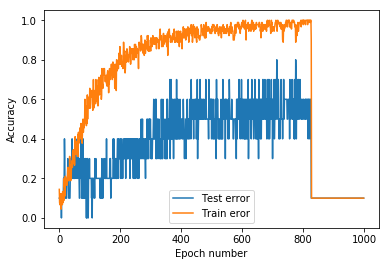

In [31]:
plt.plot(test_acc)
plt.plot(train_acc)
plt.legend(('Test error','Train eror'))
plt.xlabel('Epoch number')
plt.ylabel('Accuracy')
plt.show()